In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tabular-playground-series-sep-2021/train.csv
/kaggle/input/tabular-playground-series-sep-2021/test.csv
/kaggle/input/tabular-playground-series-sep-2021/sample_solution.csv


In [2]:
import cv2, matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
print('TF',tf.__version__)

2021-09-17 11:29:35.334297: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


TF 2.4.1


In [3]:
# RESTRICT TENSORFLOW TO 12GB OF GPU RAM
# SO THAT WE HAVE GPU RAM FOR RAPIDS CUML KNN
LIMIT = 12
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024*LIMIT)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    print(e)
print('Restrict TensorFlow to max %iGB GPU RAM'%LIMIT)
print('so RAPIDS can use %iGB GPU RAM'%(16-LIMIT))

1 Physical GPUs, 1 Logical GPUs
Restrict TensorFlow to max 12GB GPU RAM
so RAPIDS can use 4GB GPU RAM


2021-09-17 11:29:39.031933: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-09-17 11:29:39.035067: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-09-17 11:29:39.074241: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-17 11:29:39.074873: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2021-09-17 11:29:39.074936: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-09-17 11:29:39.105348: I tensorflow/stream_executor/platform/def

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import math
import time

In [5]:
import cudf, cuml, cupy
from cuml.feature_extraction.text import TfidfVectorizer
from cuml.neighbors import NearestNeighbors
print('RAPIDS',cuml.__version__)

RAPIDS 21.08.01


In [6]:
train = pd.read_csv('/kaggle/input/tabular-playground-series-sep-2021/train.csv')
test = pd.read_csv('/kaggle/input/tabular-playground-series-sep-2021/test.csv')
ss = pd.read_csv('/kaggle/input/tabular-playground-series-sep-2021/sample_solution.csv')

# Shape of train.csv, test.csv
- 'claim'이 우리가 예측해야하는 Target Column인 것을 확인 가능
- 'id'는 index인 것 같다.

In [7]:
print(train.shape)
print(test.shape)
print(ss.shape)

(957919, 120)
(493474, 119)
(493474, 2)


# Missing Values in train.csv, test.csv
- 'id', 'claim' column을 제외하고 모든 column에서 missing value들이 있는 것을 발견
- 우리는 missing value들을 처리할 방법에 대해 생각해야함..
- missing value가 너무 많은 Column은 Claim 예측할 때 빼버리거나 다르게 처리하기 위해서 nan의 count를 저장해놓은 missing_train, missing_test dataFrame을 만들었다.
- 확인해본 결과 1.5% 언저리로 결측값들이 존재하는 것을 확인하였다. 
- https://www.kaggle.com/dwin183287/tps-september-2021-eda 이 분의 것을 참고하여 시각화함 [정성추]
- Column 날리기 불가능 => 대치해야함(should have to impute)

In [8]:
perfect_train_column = []
perfect_test_column = []
for col in train:
    if train[col].isnull().sum() == 0:
        perfect_train_column.append(col)
        
for col in test:
    if test[col].isnull().sum() == 0:
        perfect_test_column.append(col)
        
print(perfect_train_column)
print(perfect_test_column)

['id', 'claim']
['id']


In [9]:
# f, ax = plt.subplots(figsize = (20, 20))
# sns.barplot(y = missing_train['count'], x = missing_train['column_name'])

# dtype of train.csv, test.csv
- dtype이 여러 종류인지 확인해야함 -> float, int, category, object등으로 나누는 것
- dtype이 float인 column이 118개, int인 column이 2개로 나타남
- dtype이 int인 column은 id와 claim으로 나타남
- float인 column들의 분포를 살펴봐야겠다.
- float인 column들이 진짜로 연속형 Column인지 확인 위해 train set, test set에 대해 kdeplot 찍어보자

In [10]:
float_ls = []
int_ls = []
cat_ls = []
object_ls = []
bool_ls = []
other_ls = []

for col in train:
    if train[col].dtype == 'float64':
        float_ls.append(col)
    elif train[col].dtype == 'int64':
        int_ls.append(col)
    elif train[col].dtype == 'category':
        cat_ls.append(col)
    elif train[col].dtype == 'object':
        object_ls.append(col)
    elif train[col].dtype == 'bool':
        bool_ls.append(col)
    else :
        other_ls.append(col)
        
print('float type columns count: ', len(float_ls))
print('int type columns count: ', len(int_ls))
print('category type columns count: ', len(cat_ls))
print('object type columns count: ', len(object_ls))
print('bool type columns count: ', len(bool_ls))
print('other type columns count: ', len(other_ls))

float type columns count:  118
int type columns count:  2
category type columns count:  0
object type columns count:  0
bool type columns count:  0
other type columns count:  0


In [11]:
print(int_ls)

['id', 'claim']


# Using Kdeplot to see columns distribution
- Kdeplot 이용해서 column들 찍어봅시다
- 118개 Column이니 25개씩 5번 살펴봐봅시다
- 살펴본 결과 train과 test의 분포가 많이 비슷하다는 것을 볼 수 있었다.
- 노란색은 train set / 검은색은 test set

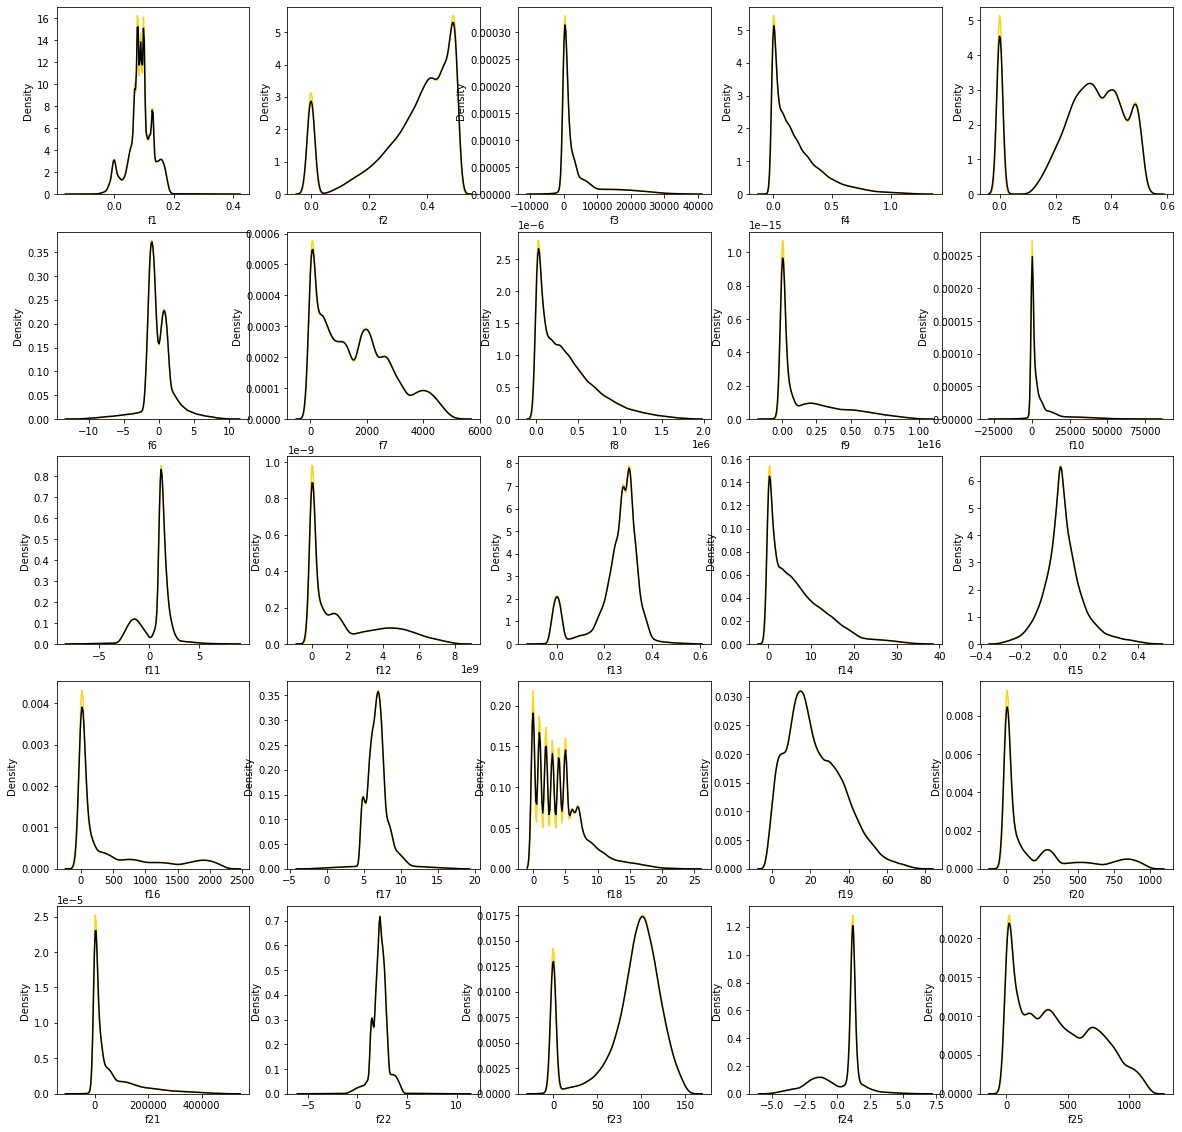

In [12]:
f, ax = plt.subplots(5, 5, figsize=(20, 20))

play = 0
for col in float_ls[:25]:
    sns.kdeplot(train[col], color = '#ffd514', ax=ax[int(play / 5)][play % 5])
    sns.kdeplot(test[col], color = '#000000', ax=ax[int(play / 5)][play % 5])
    play += 1

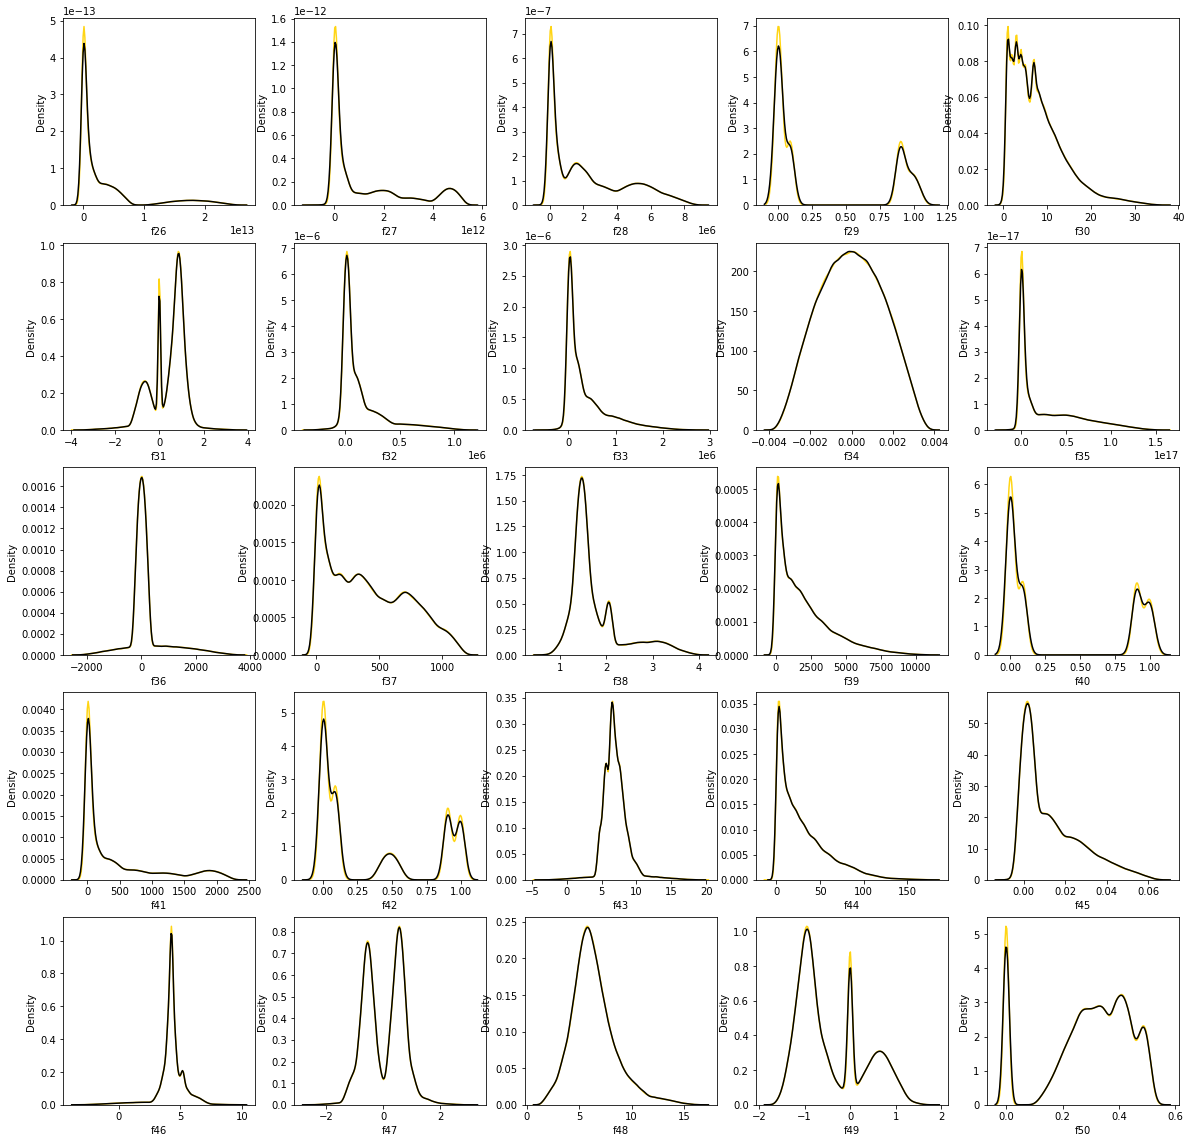

In [13]:
f, ax = plt.subplots(5, 5, figsize=(20, 20))
play = 0
for col in float_ls[25:50]:
    sns.kdeplot(train[col], color = '#ffd514', ax=ax[int(play / 5)][play % 5])
    sns.kdeplot(test[col], color = '#000000', ax=ax[int(play / 5)][play % 5])
    play += 1

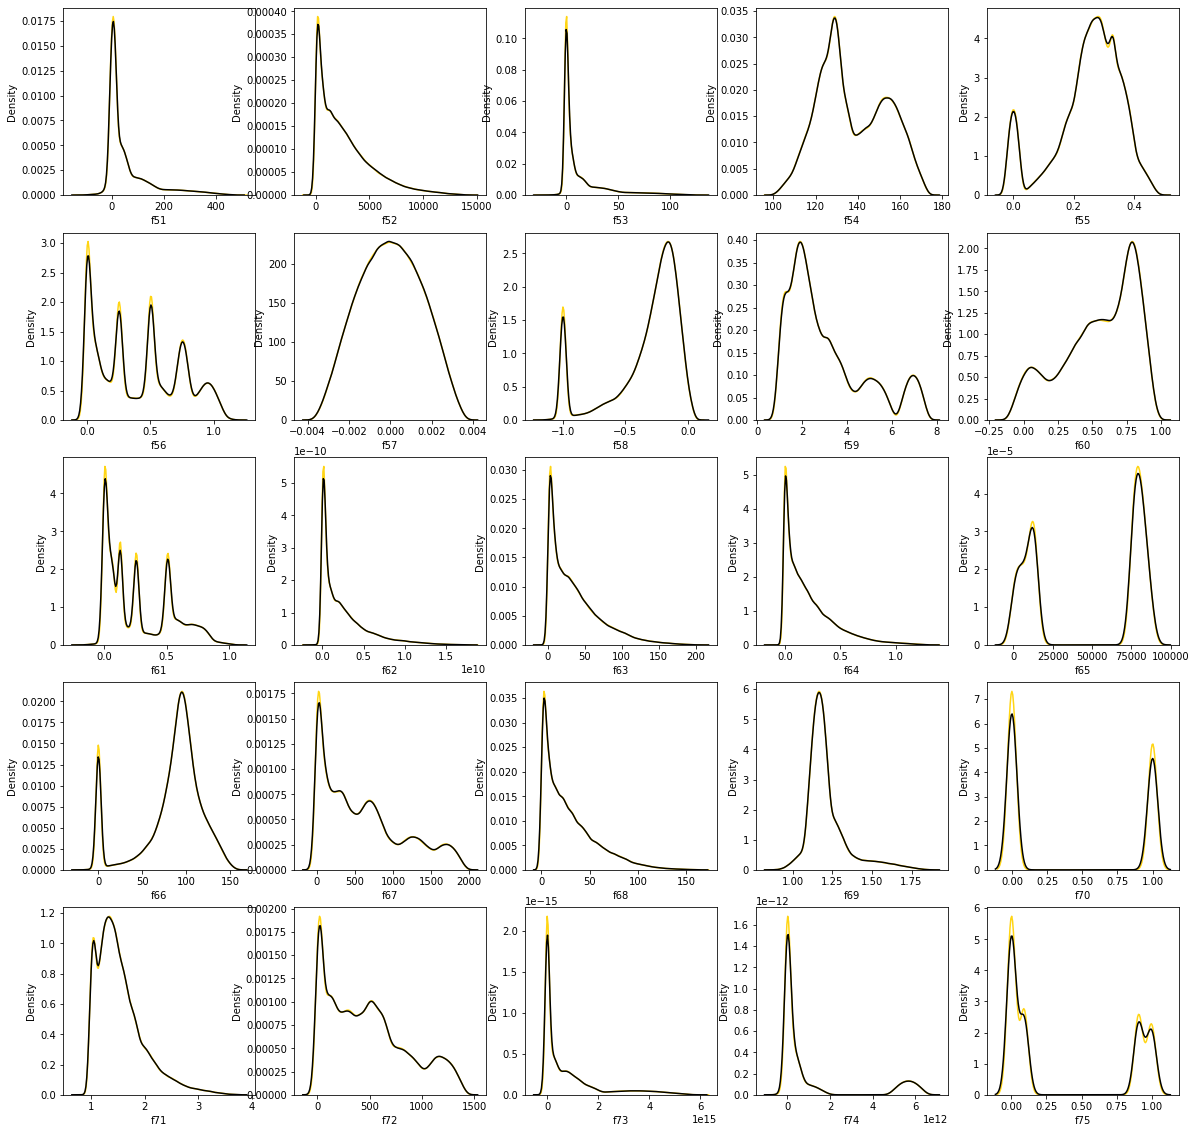

In [14]:
f, ax = plt.subplots(5, 5, figsize=(20, 20))
play = 0
for col in float_ls[50:75]:
    sns.kdeplot(train[col], color = '#ffd514', ax=ax[int(play / 5)][play % 5])
    sns.kdeplot(test[col], color = '#000000', ax=ax[int(play / 5)][play % 5])
    play += 1

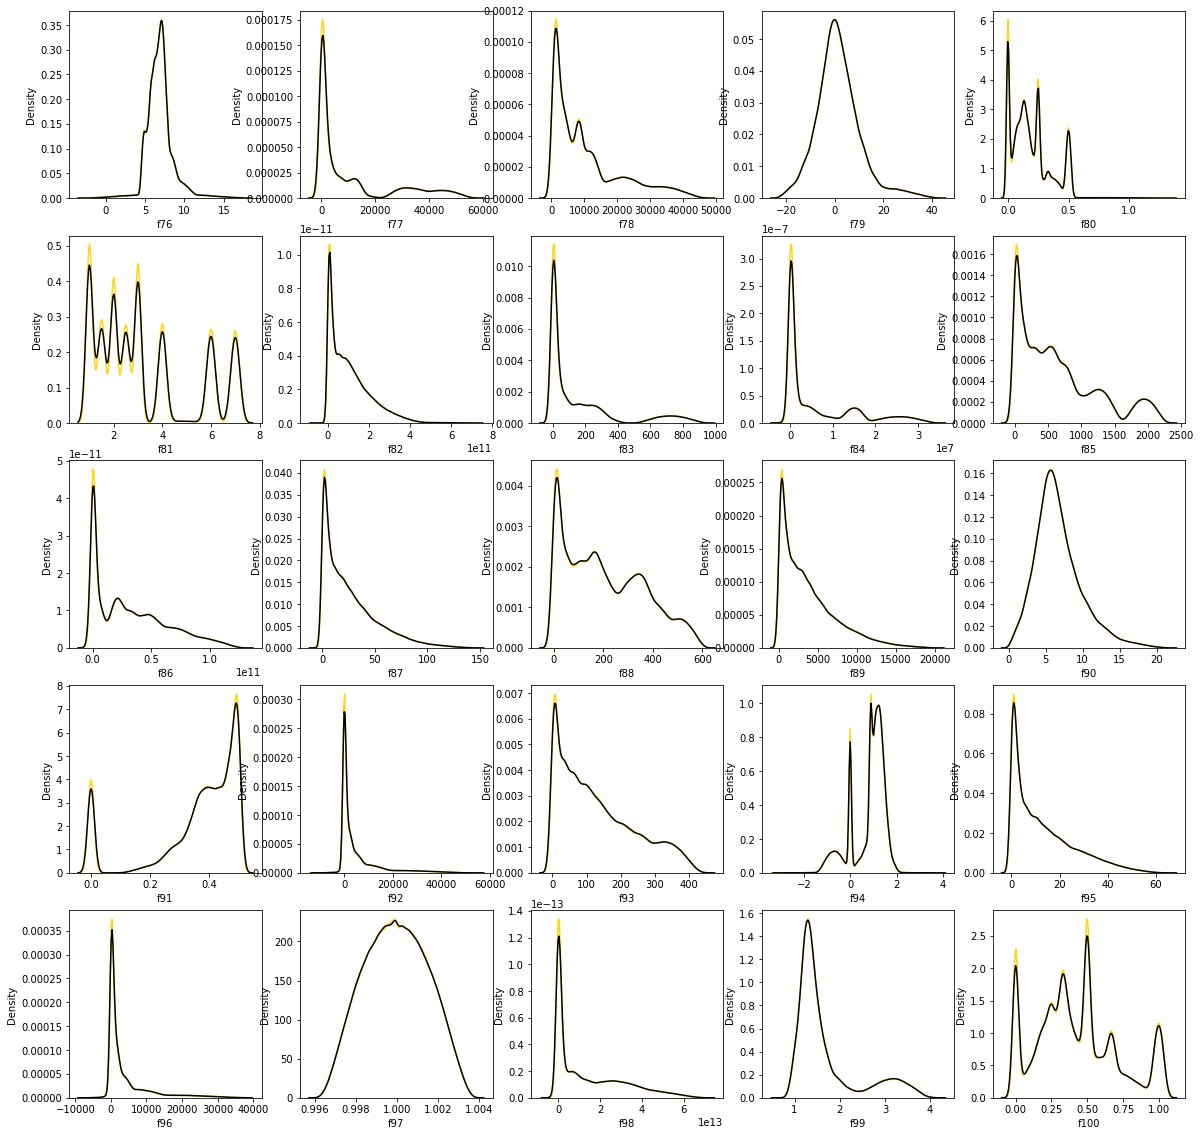

In [15]:
f, ax = plt.subplots(5, 5, figsize=(20, 20))
play = 0
for col in float_ls[75:100]:
    sns.kdeplot(train[col], color = '#ffd514', ax=ax[int(play / 5)][play % 5])
    sns.kdeplot(test[col], color = '#000000', ax=ax[int(play / 5)][play % 5])
    play += 1

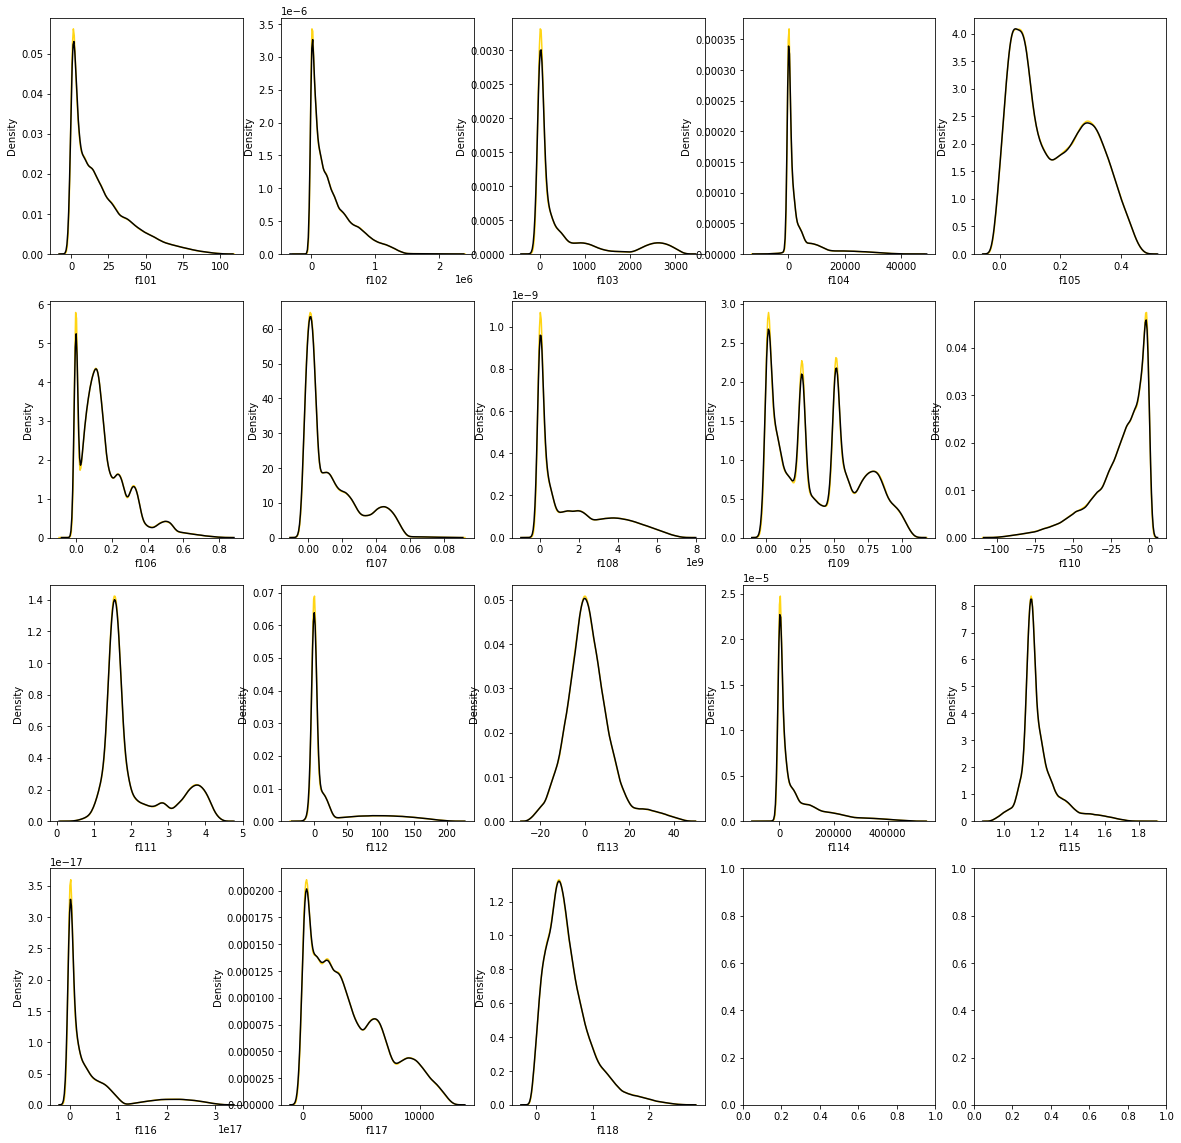

In [16]:
f, ax = plt.subplots(4, 5, figsize=(20, 20))
play = 0
for col in float_ls[100:]:
    sns.kdeplot(train[col], color = '#ffd514', ax=ax[int(play / 5)][play % 5])
    sns.kdeplot(test[col], color = '#000000', ax=ax[int(play / 5)][play % 5])
    play += 1

# Column distribution group by Claim
- claim이 0인지 1인지에 따라 각 Column이 가지는 분포를 보고 싶음
- claim이 0이든 1이든 분포가 비슷하게 나와서 큰 의미가 없었다.(비슷하다는 것을 알아냄)

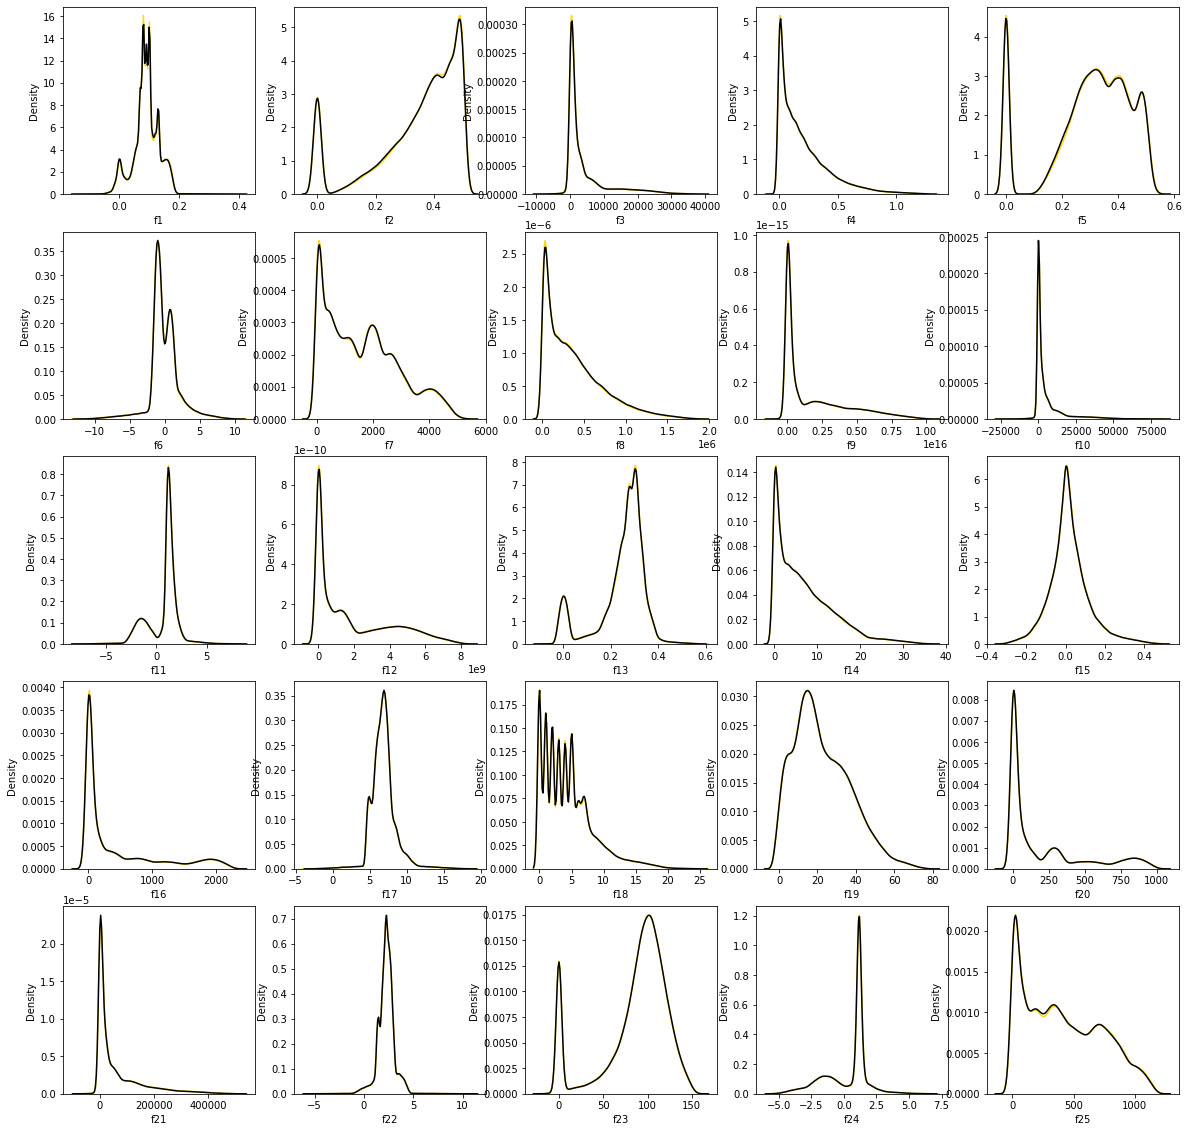

In [17]:
f, ax = plt.subplots(5, 5, figsize=(20, 20))

play = 0
for col in float_ls[:25]:
    sns.kdeplot(train[(train['claim'] == 0)][col], color = '#ffd514', ax=ax[int(play / 5)][play % 5])
    sns.kdeplot(train[(train['claim'] == 1)][col], color = '#000000', ax=ax[int(play / 5)][play % 5])
    play += 1

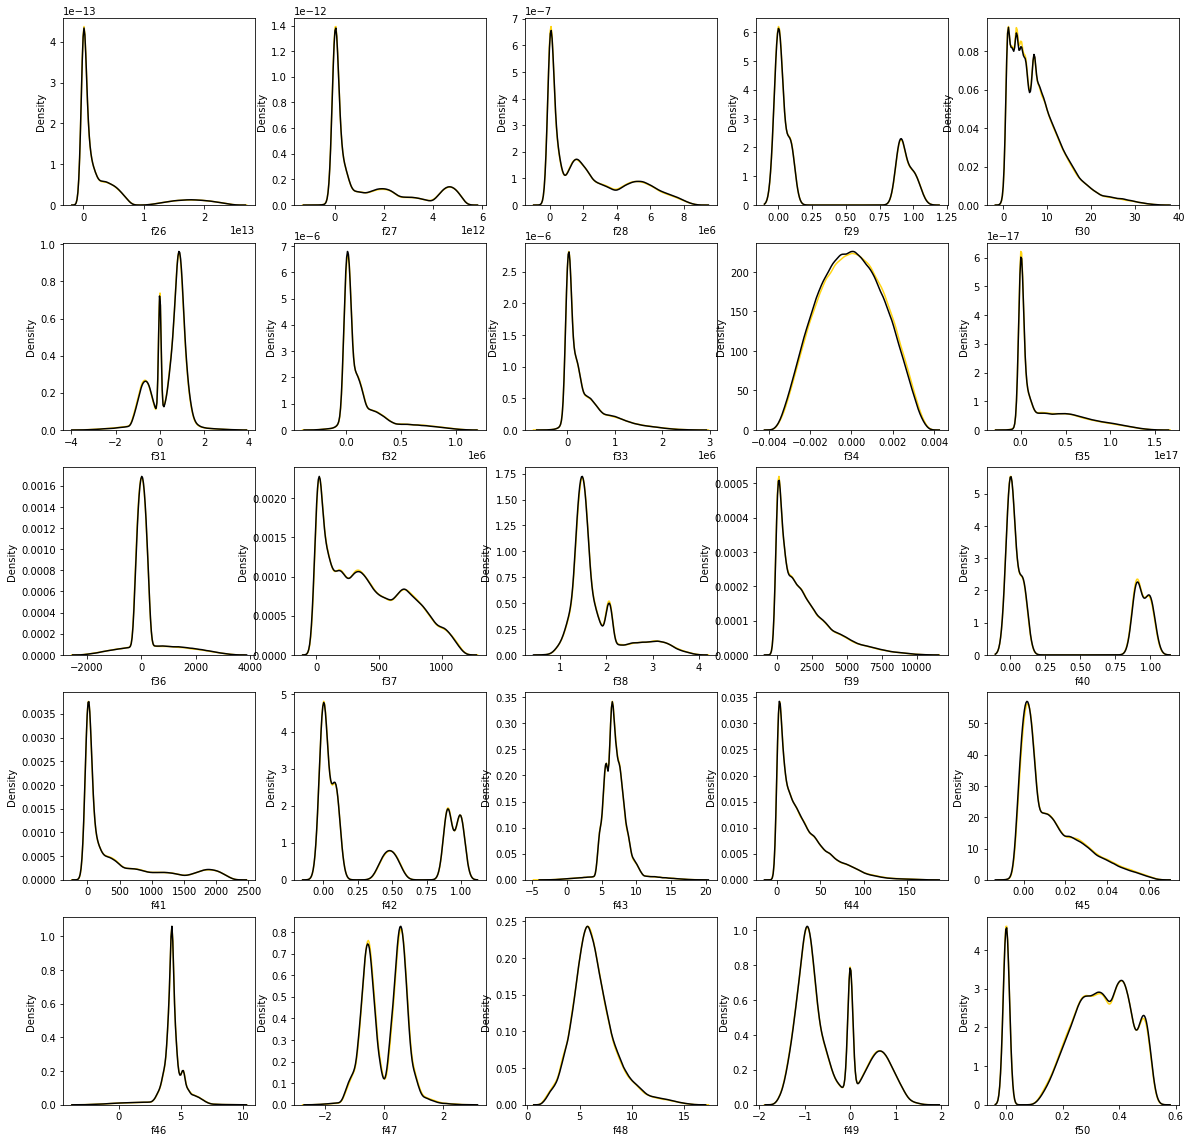

In [18]:
f, ax = plt.subplots(5, 5, figsize=(20, 20))

play = 0
for col in float_ls[25:50]:
    sns.kdeplot(train[(train['claim'] == 0)][col], color = '#ffd514', ax=ax[int(play / 5)][play % 5])
    sns.kdeplot(train[(train['claim'] == 1)][col], color = '#000000', ax=ax[int(play / 5)][play % 5])
    play += 1

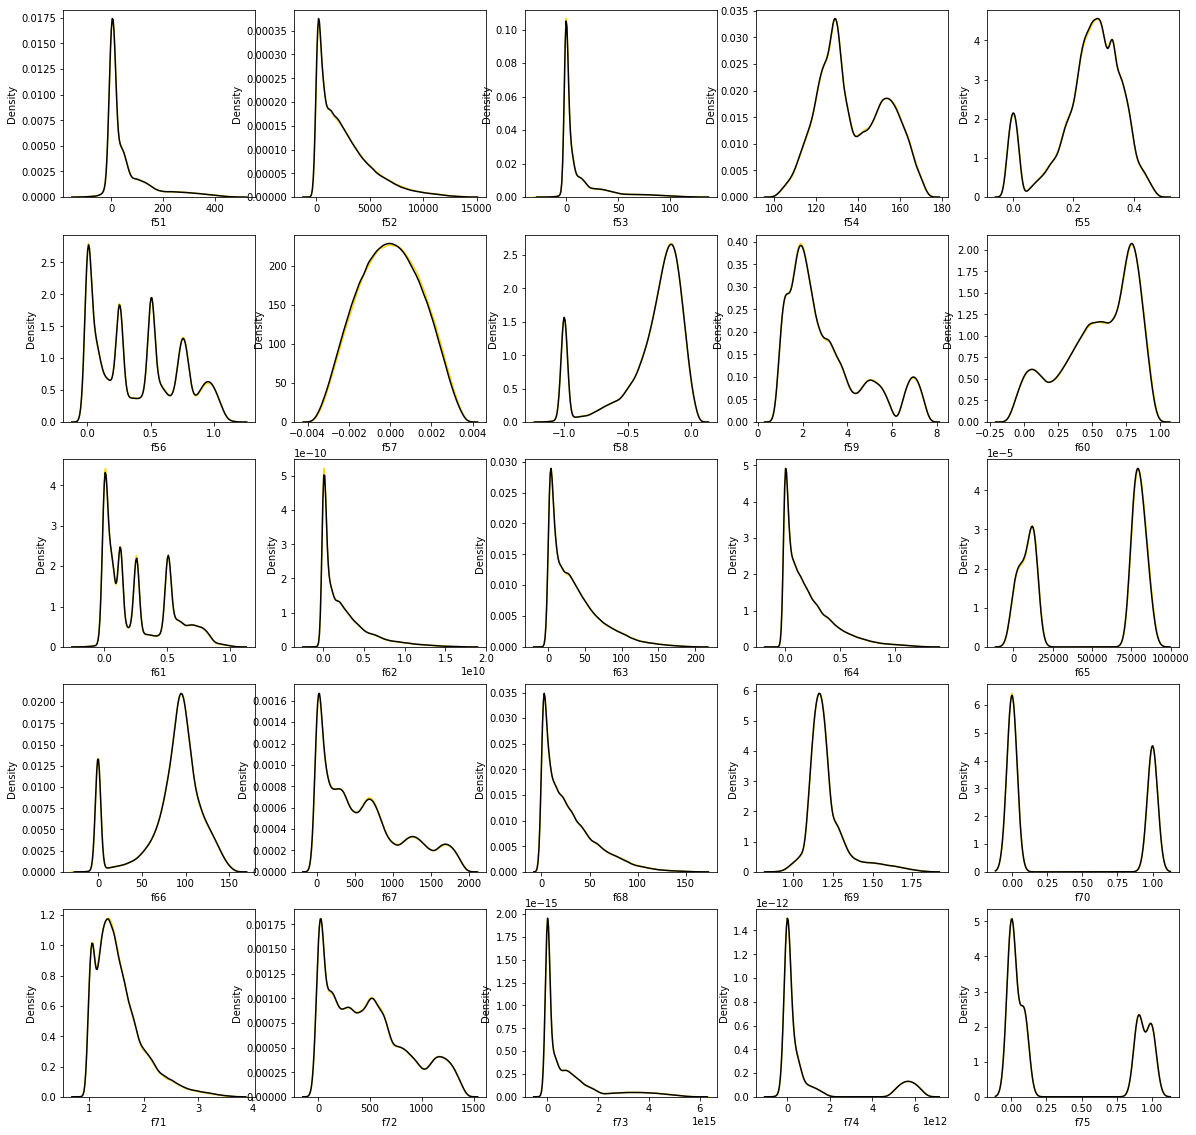

In [19]:
f, ax = plt.subplots(5, 5, figsize=(20, 20))

play = 0
for col in float_ls[50:75]:
    sns.kdeplot(train[(train['claim'] == 0)][col], color = '#ffd514', ax=ax[int(play / 5)][play % 5])
    sns.kdeplot(train[(train['claim'] == 1)][col], color = '#000000', ax=ax[int(play / 5)][play % 5])
    play += 1

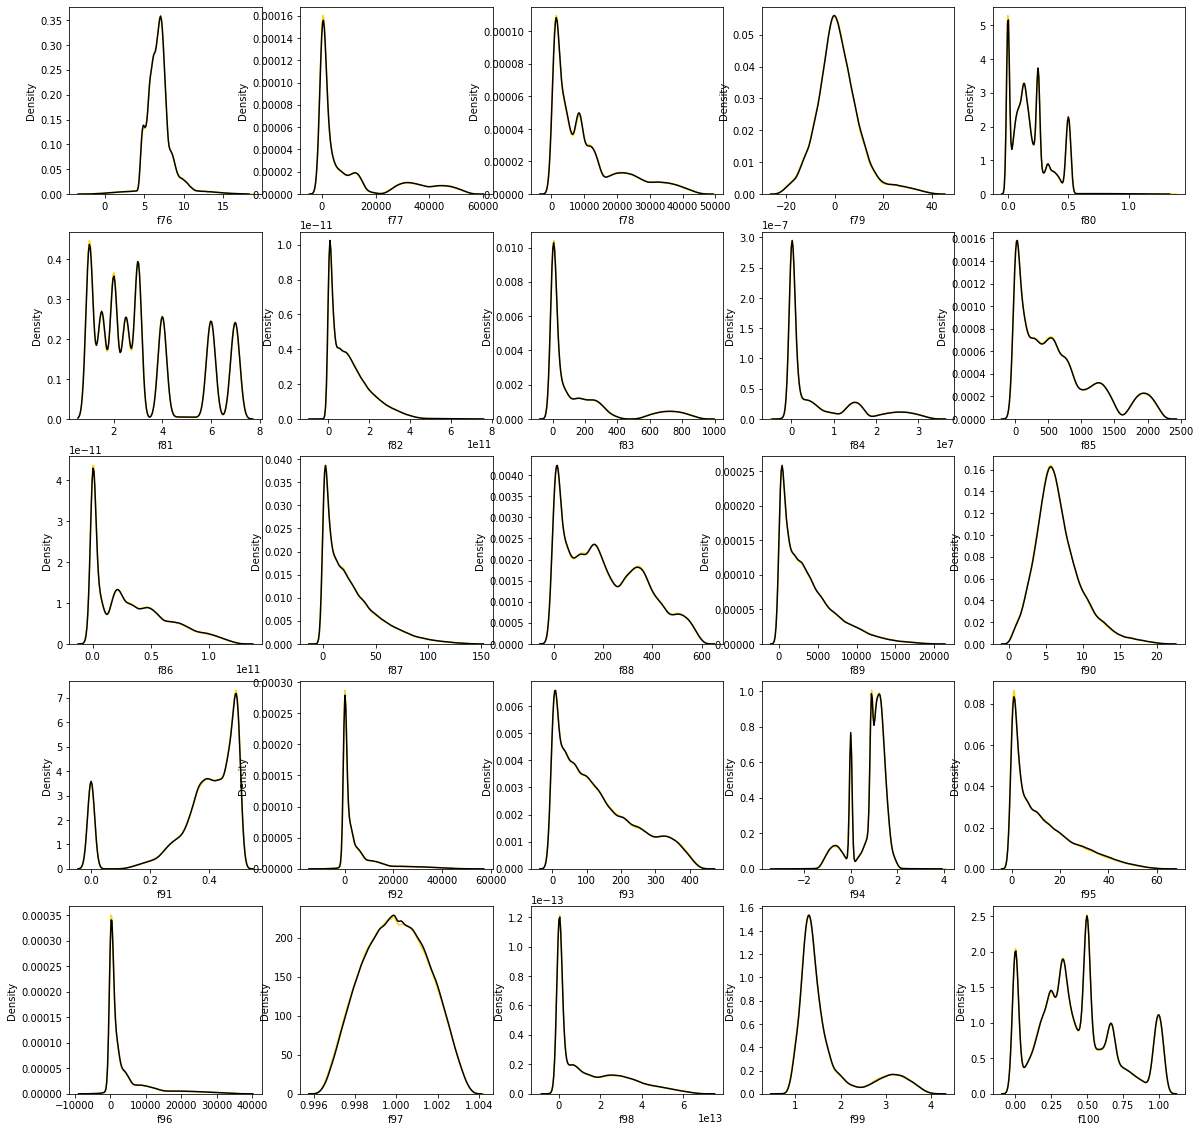

In [20]:
f, ax = plt.subplots(5, 5, figsize=(20, 20))

play = 0
for col in float_ls[75:100]:
    sns.kdeplot(train[(train['claim'] == 0)][col], color = '#ffd514', ax=ax[int(play / 5)][play % 5])
    sns.kdeplot(train[(train['claim'] == 1)][col], color = '#000000', ax=ax[int(play / 5)][play % 5])
    play += 1

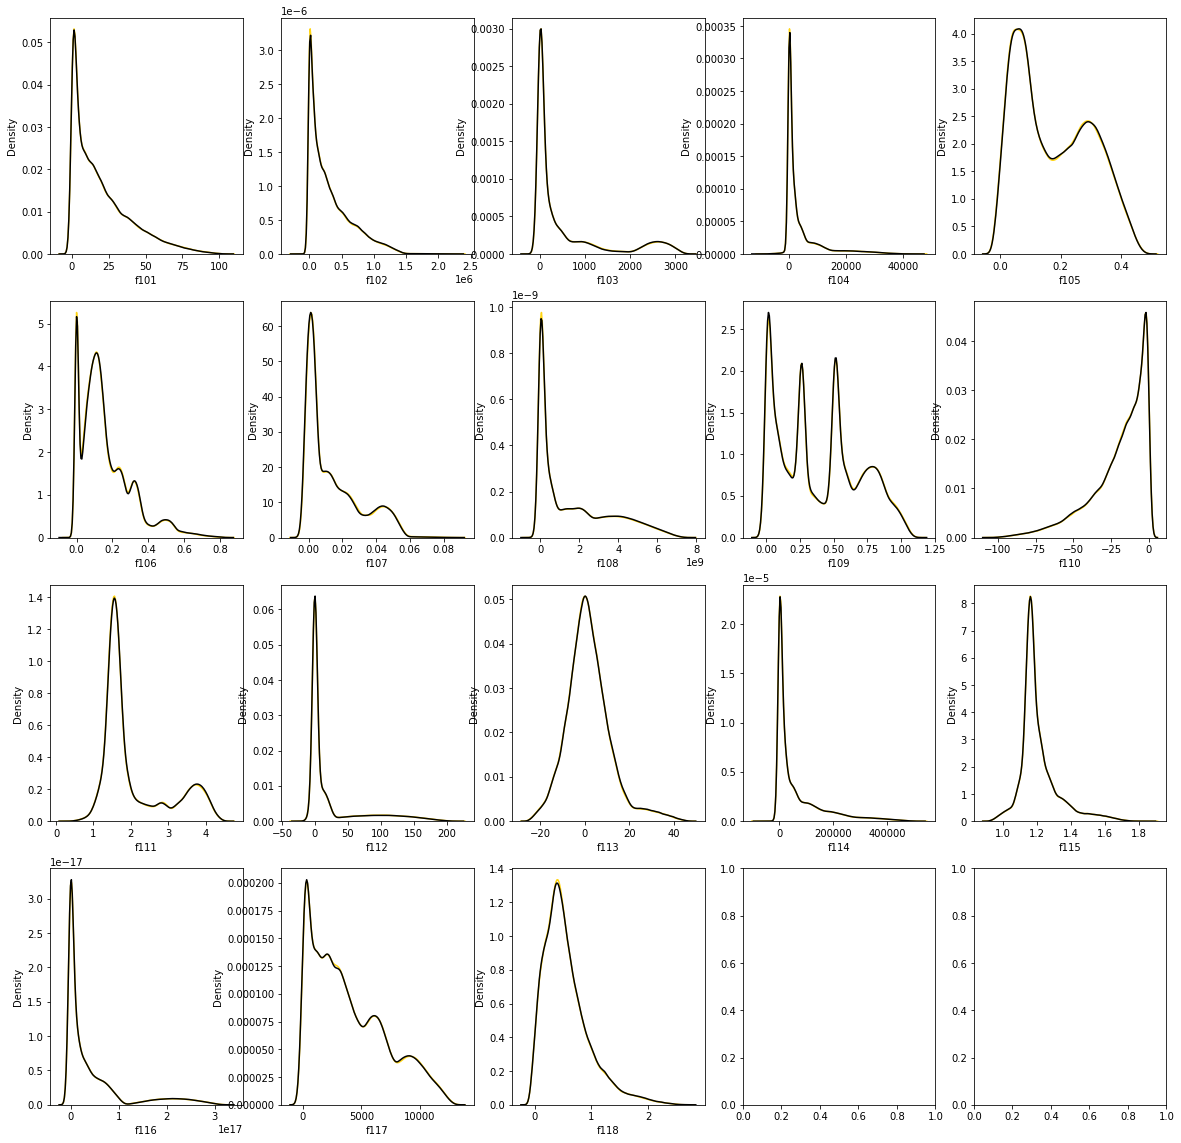

In [21]:
f, ax = plt.subplots(4, 5, figsize=(20, 20))

play = 0
for col in float_ls[100:]:
    sns.kdeplot(train[(train['claim'] == 0)][col], color = '#ffd514', ax=ax[int(play / 5)][play % 5])
    sns.kdeplot(train[(train['claim'] == 1)][col], color = '#000000', ax=ax[int(play / 5)][play % 5])
    play += 1

# Correlations between each columns
- 각 Column들간 연관관계를 살펴보자
- 자기 자신과의 correlation == 1인데 118개의 0.1보다 큰 상관관계가 관측되었다는 것은
- 즉 서로 상관관계가 있는 Column들이 없다는 뜻

In [22]:
corrs = train[float_ls].corr()

In [23]:
len(abs(corrs) > 0.1)

118

# Handling Missing Values
- 결측치를 내 스스로 채우고 진행 vs 결측값을 채워주는 알고리즘 ex) LGBM 사용
- 우선 결측치를 채우고 진행하는